#**Processing data**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix

from sklearn.model_selection import train_test_split
%matplotlib inline

DATA = 'ADFA-LD'

import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [28]:
# Load data and unzip them
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true'
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Attack_Data_Master.zip?raw=true'


--2021-09-29 01:48:33--  https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2021-09-29 01:48:34--  https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2021-09-29 01:48:34--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [ ]:
# Rename files
! mv Attack_Data_Master.zip?raw=true   Attack_Data_Master.zip
! mv Training_Data_Master.zip?raw=true Training_Data_Master.zip

# Unzip files
! unzip Training_Data_Master.zip
! unzip Attack_Data_Master.zip

In [30]:
from glob import glob
import os
train_dir = 'Training_Data_Master/'
test_dir  = 'Attack_Data_Master/'

# Read data in a dataframe
def read_in_data(path, is_normal = 1): 
  list_of_dataframes = []
  if is_normal == 1:
    for filename in os.listdir(path): # iterate through all label folders in a directory [buildings, forest, glacier, mountain, sea, street]
        data = pd.read_csv(path+filename, sep=' ', header=None)
        list_of_dataframes.append(data.stack())
    
  else:
    for folder in os.listdir(path): # iterate through all label folders in a directory [buildings, forest, glacier, mountain, sea, street]
      files = glob(str(path + folder +"/*.txt"), recursive=False) # get a list of jpg files from each label folder 
      for filename in files: 
        data = pd.read_csv(filename, sep=' ', header=None)
        list_of_dataframes.append(data.stack())

  df = pd.concat(list_of_dataframes)
  df = df.astype('int32')
  df = pd.DataFrame(df)
  return df   

In [31]:
# Trainning set
train = read_in_data(train_dir)
train.rename(columns={0:'Syscall'}, inplace=True)
train = train.droplevel(level=0, axis = 0)
print('Normal training data size:', train.shape)
train.head(5)

Normal training data size: (308077, 1)


,Syscall
0,6
1,91
2,11
3,45
4,221


In [32]:
# Testing set
test = read_in_data(test_dir, is_normal = 0)
test.rename(columns={0:'Syscall'}, inplace=True)
test = test.droplevel(level=0, axis = 0)
print('Intrusion Testing data size:', test.shape)
test.head(5)

Intrusion Testing data size: (317388, 1)


,Syscall
0,197
1,91
2,3
3,3
4,3


## **EDA - Histogram of original data**



Text(0.5, 1.02, 'An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ADFA-LD')

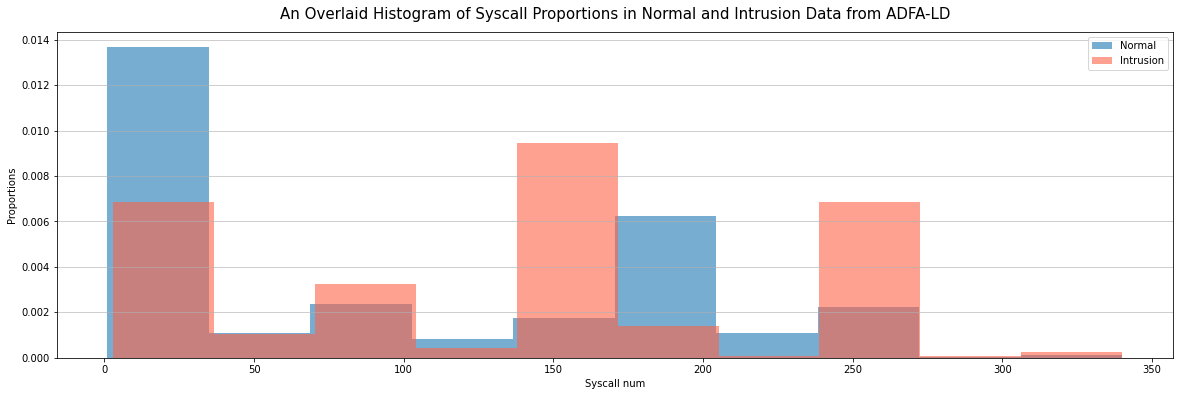

In [33]:
plt.figure(figsize=(20,6))
plt.hist(train['Syscall'], label='Normal', alpha=0.6, density=True)
plt.hist(test['Syscall'], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

In [34]:
## Tokenizing syscall sequences into n-grams of 6

from nltk.tokenize import word_tokenize
from nltk import ngrams

def process_data(df):
  ## Convert elements in Syscall col into string of NORMAL sequence
  syscall_names = df.to_string(columns = ['Syscall'], index=False, header = False)

  token = word_tokenize(syscall_names)  # Tokenize the string of sequence

  # Parse the sequence into length of 6
  sequence_list = list(nltk.ngrams(token,6))

  df_sequence = pd.DataFrame(sequence_list)
  df = df_sequence.astype('int32')
  return df

In [35]:
train = process_data(train)
print(train.shape)
train.head(5)

(308072, 6)


,0,1,2,3,4,5
0,6,91,11,45,221,221
1,91,11,45,221,221,221
2,11,45,221,221,221,33
3,45,221,221,221,33,33
4,221,221,221,33,33,192


In [36]:
test = process_data(test)
print(test.shape)
test.head(5)

(317383, 6)


,0,1,2,3,4,5
0,197,91,3,3,3,3
1,91,3,3,3,3,3
2,3,3,3,3,3,3
3,3,3,3,3,3,3
4,3,3,3,3,3,195


 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df

In [37]:
train

,0,1,2,3,4,5
0,6,91,11,45,221,221
1,91,11,45,221,221,221
2,11,45,221,221,221,33
3,45,221,221,221,33,33
4,221,221,221,33,33,192
...,...,...,...,...,...,...
308067,195,6,6,195,195,195
308068,6,6,195,195,195,195
308069,6,195,195,195,195,195
308070,195,195,195,195,195,195


In [38]:
test

,0,1,2,3,4,5
0,197,91,3,3,3,3
1,91,3,3,3,3,3
2,3,3,3,3,3,3
3,3,3,3,3,3,3
4,3,3,3,3,3,195
...,...,...,...,...,...,...
317378,146,168,3,3,168,146
317379,168,3,3,168,146,3
317380,3,3,168,146,3,3
317381,3,168,146,3,3,265


In [39]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )

  c_intrusion = intrusion_set - normal_set
  c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0 and len(c_normal) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  if len(c_normal) > 0:
    normal = pd.DataFrame(c_normal)
  else:
    normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(c_normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

normal, intrusion = clean_data(train, test) # since train set contains only normal, it is passed in the func as normal. Similar to test

List sz vs. Set sz of normal sequences: 308072 vs. 63372
List sz vs. Set sz of intrusion sequences: 317383 vs. 70748
After cleaning: 
Normal sz: 59111  Intrusion sz: 66487


In [40]:
len(normal), len(intrusion)

(59111, 66487)

## **Histogram of Processed Data**

Text(0.5, 1.02, 'An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ADFA-LD')

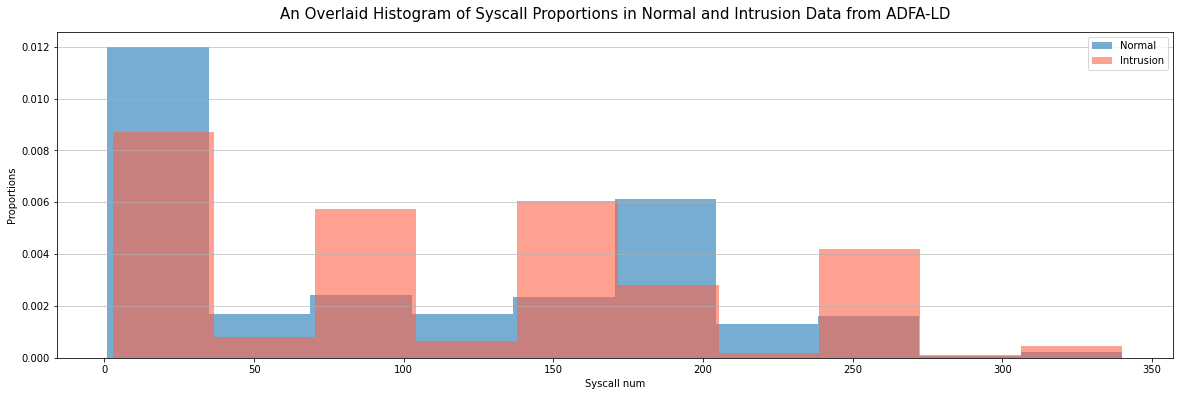

In [41]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

In [42]:
# Save cleaned train and test sets
normal.to_csv('normal.csv', index=False)
intrusion.to_csv('intrusion.csv', index=False)

**Labeling Sequences**

In [43]:
# Intrusion sequences is labeled 1. Rename columns of the dataframe
intrusion['Label'] = 1
intrusion.rename(columns={0: 'Position1', 1: 'Position2', 2: 'Position3', 3: 'Position4',
                          4: 'Position5', 5: 'Position6'}, inplace=True)

print(intrusion.head(5), '\n')

   Position1  Position2  Position3  Position4  Position5  Position6  Label
0        175        175        119        142        142          3      1
1        146        265        168          3        168          3      1
2          3          3        142        142        142        142      1
3         54        265          3        265        146          3      1
4        256        240        256        102        240        102      1 



In [44]:
# Normal sequences is labeled 0. Rename columns of the dataframe
normal['Label'] = 0
normal.rename(columns={0: 'Position1', 1: 'Position2', 2: 'Position3', 3: 'Position4',
                        4: 'Position5', 5: 'Position6'}, inplace=True)
print(normal.head(5), '\n')

print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))

   Position1  Position2  Position3  Position4  Position5  Position6  Label
0        195        195          3          5          3          3      0
1          3          3        265        265        221        265      0
2        175        175         45        175          5        221      0
3         78        180        180        180        125        180      0
4         78        265          3        265        168        168      0 

Normal len: 59111 
Intrusion len: 66487


## **Partition Training and Testing dataset 70/30**

We do not need to bootstrap since there are more than enough data from both classes.

In [45]:
# combine normal(train) and intrusion(test) data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:6], df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (125598, 7)
Train sz: 87918 87918
Train set: Intrusion vs. Normal cases 46482 41436
Test sz: 37680 37680
Test set: Intrusion vs. Normal cases 20005 17675


# Bootstrap training data
## Lived-name has more intrusion cases than normal cases (189 > 71) --> bootstrap normal cases only
x_train['Label'] = y_train
if len(intrusion_train) > len(normal_train):
  x_train = x_train.iloc[intrusion_train.index].append(x_train.iloc[normal_train.index].sample(n = len(intrusion_train), replace=True), ignore_index=True) #upsampled normal data and add to train set
else:
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac=1) # Shuffle data
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

In [46]:
y_train

0        0
1        1
2        0
3        0
4        0
        ..
87913    0
87914    1
87915    1
87916    0
87917    0
Name: Label, Length: 87918, dtype: int64


# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [47]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance(model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  plt.title( model_name+' ROC Curve on ' + DATA)
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# **K-means**

Confusion Matrix: 
 [[11120  6555]
 [ 9317 10688]]

Testing Accuracy: 0.58
Precision:0.62
Recall: 0.53
False Positive Rate: 0.37

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.63      0.58     17675
           1       0.62      0.53      0.57     20005

    accuracy                           0.58     37680
   macro avg       0.58      0.58      0.58     37680
weighted avg       0.58      0.58      0.58     37680

AUC: 0.58


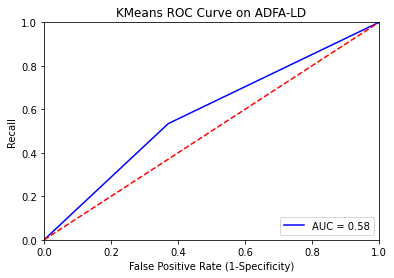

Number of iterations before converging: 10
Train AUC: 0.581 vs Test AUC: 0.582


In [48]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR for the TRAINING ROC curves
y_pred = kmeans.predict(x_train)
KM_train = {}
KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
KM_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING K-MEANS
y_predicted = kmeans.predict(x_test)

print_performance('KMeans',y_test, y_predicted)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)


# Recording TPR and FPR for the TESTING ROC curves
KM_test = {}
KM_test['fpr'], KM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KM_test['auc'] = roc_auc_score(y_test, y_predicted)


print('Train AUC: %.3f vs Test AUC: %.3f' %(KM_train['auc'], KM_test['auc']))

# **Logistic Regression**

Confusion Matrix: 
 [[ 8577  9098]
 [ 6303 13702]]

Testing Accuracy: 0.59
Precision:0.60
Recall: 0.68
False Positive Rate: 0.51

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.49      0.53     17675
           1       0.60      0.68      0.64     20005

    accuracy                           0.59     37680
   macro avg       0.59      0.59      0.58     37680
weighted avg       0.59      0.59      0.59     37680

AUC: 0.59


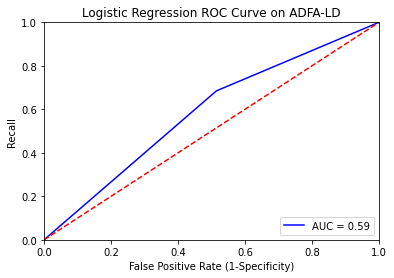

Train AUC: 0.585 vs Test AUC: 0.585


In [49]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set and predict the testing set
lgModel = LogisticRegression().fit(x_train, y_train)
y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
LR_train = {}
LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
LR_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING Logistic Regression
y_predicted = lgModel.predict(x_test)

# Evaluating Performance on Testing data
print_performance('Logistic Regression',y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
LR_test = {}
LR_test['fpr'], LR_test['tpr'], thresh = roc_curve(y_test, y_predicted)
LR_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(LR_train['auc'], LR_test['auc']))

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






# reduce data to train for SVM as it takes too long

train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = 0.1)
train_data.reset_index(drop=True, inplace= True)
#train_data
svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

In [50]:
svm_y_train = y_train
svm_y_train

0        0
1        1
2        0
3        0
4        0
        ..
87913    0
87914    1
87915    1
87916    0
87917    0
Name: Label, Length: 87918, dtype: int64

In [51]:
svm_x_train = x_train
svm_x_train

,Position1,Position2,Position3,Position4,Position5,Position6
0,265,168,331,265,265,146
1,3,3,3,220,91,195
2,3,6,195,5,3,45
3,240,240,78,242,78,240
4,63,114,195,120,114,120
...,...,...,...,...,...,...
87913,3,175,54,54,3,54
87914,265,104,265,142,142,3
87915,265,146,104,142,265,104
87916,3,5,54,140,197,221



****Polynomial kernel model: 
[LibSVM]Confusion Matrix: 
 [[13022  4653]
 [10193  9812]]

Testing Accuracy: 0.61
Precision:0.68
Recall: 0.49
False Positive Rate: 0.26

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.74      0.64     17675
           1       0.68      0.49      0.57     20005

    accuracy                           0.61     37680
   macro avg       0.62      0.61      0.60     37680
weighted avg       0.62      0.61      0.60     37680

AUC: 0.61


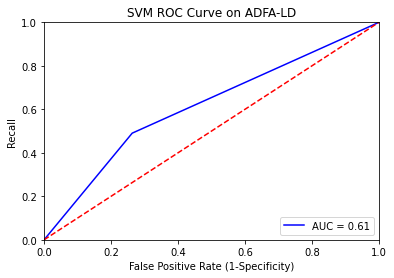

Train AUC: 0.613 vs Test AUC: 0.614


In [52]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly', verbose = True)

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)
y_pred = svm_model.predict(svm_x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
SVM_train = {}
SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(svm_y_train, y_pred)
SVM_train['auc'] = roc_auc_score(svm_y_train, y_pred)


# Test the model w testing data
y_predicted = svm_model.predict(x_test)

# Evaluate the model 
print_performance('SVM', y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
SVM_test = {}
SVM_test['fpr'], SVM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
SVM_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(SVM_train['auc'], SVM_test['auc']))

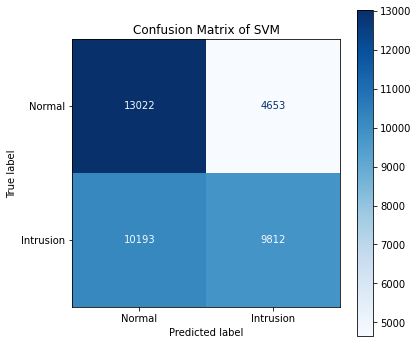

[[13022  4653]
 [10193  9812]]


In [53]:
# Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [54]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in ADFA-LD data is 325
max_syscall = 325
x_train_nn = x_train/max_syscall
x_test_nn = x_test/max_syscall

In [56]:
import tensorflow as tf
from tensorflow import keras

nn_model = keras.Sequential([
    keras.layers.Input(shape = (6,)),  # model expect input to be a vector of 6 numbers
    keras.layers.Dense(6, activation = 'relu'),
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size=64, verbose=1)  # we pass the data, labels and epochs and watch the magic!

Epoch 1/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6803 - accuracy: 0.5726
Epoch 2/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6723 - accuracy: 0.5900
Epoch 3/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6683 - accuracy: 0.5934
Epoch 4/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6654 - accuracy: 0.5930
Epoch 5/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6636 - accuracy: 0.5926
Epoch 6/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6624 - accuracy: 0.5925
Epoch 7/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6618 - accuracy: 0.5923
Epoch 8/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6614 - accuracy: 0.5938
Epoch 9/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.6611 - accuracy: 0.5929
Epoch 10/10
1374/1374 [==============================] - 4s 3ms/step - loss: 0.661

In [57]:
# Get predict Training classes
y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
NN_train = {}
NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
NN_train['auc'] = roc_auc_score(y_train, y_pred)

1178/1178 [==============================] - 3s 2ms/step - loss: 0.6596 - accuracy: 0.5891
Test accuracy: 0.5890923738479614  Test loss: 0.6595627665519714
Confusion Matrix: 
 [[10404  7271]
 [ 8212 11793]]

Testing Accuracy: 0.59
Precision:0.62
Recall: 0.59
False Positive Rate: 0.41

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.59      0.57     17675
           1       0.62      0.59      0.60     20005

    accuracy                           0.59     37680
   macro avg       0.59      0.59      0.59     37680
weighted avg       0.59      0.59      0.59     37680

AUC: 0.59


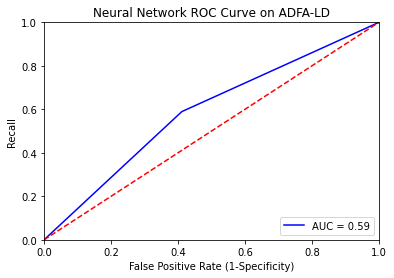

Train AUC: 0.591 vs Test AUC: 0.589


In [58]:
# Get the loss and accuracy on testing set
test_loss, test_acc = nn_model.evaluate(x_test_nn,  y_test, verbose=1) 
y_predicted = np.argmax(nn_model.predict(x_test_nn), axis=-1)


print('Test accuracy:', test_acc,' Test loss:', test_loss)
print_performance('Neural Network',y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NN_test = {}
NN_test['fpr'], NN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NN_train['auc'], NN_test['auc']))

In [59]:
nn_model.summary()

#history.history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 14        
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

Confusion Matrix: 
 [[14146  3529]
 [ 4109 15896]]

Testing Accuracy: 0.80
Precision:0.82
Recall: 0.79
False Positive Rate: 0.20

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79     17675
           1       0.82      0.79      0.81     20005

    accuracy                           0.80     37680
   macro avg       0.80      0.80      0.80     37680
weighted avg       0.80      0.80      0.80     37680

AUC: 0.80


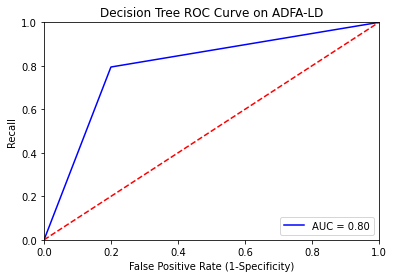

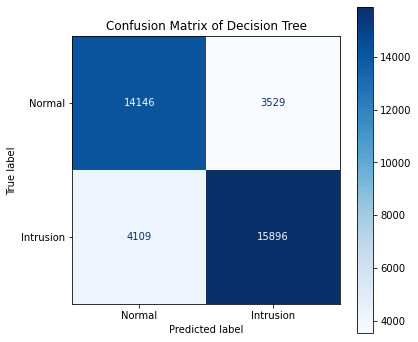

[[14146  3529]
 [ 4109 15896]]
Train AUC: 0.869 vs Test AUC: 0.797


In [60]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = {}
DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
DT_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print_performance('Decision Tree',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Decision Tree', decTree, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = {}
DT_test['fpr'], DT_test['tpr'], thresh = roc_curve(y_test, y_predicted)
DT_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(DT_train['auc'], DT_test['auc']))

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.




Confusion Matrix: 
 [[15254  2421]
 [ 2946 17059]]

Testing Accuracy: 0.86
Precision:0.88
Recall: 0.85
False Positive Rate: 0.14

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     17675
           1       0.88      0.85      0.86     20005

    accuracy                           0.86     37680
   macro avg       0.86      0.86      0.86     37680
weighted avg       0.86      0.86      0.86     37680

AUC: 0.86


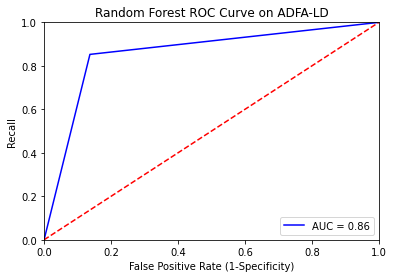

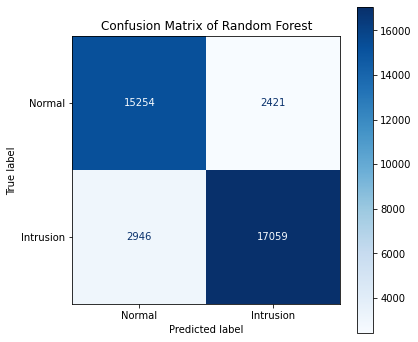

[[15254  2421]
 [ 2946 17059]]
Train AUC: 0.918 vs Test AUC: 0.858


In [61]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = {}
RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
RF_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print_performance('Random Forest',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Random Forest', randomForest, x_test, y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
RF_test = {}
RF_test['fpr'], RF_test['tpr'], thresh = roc_curve(y_test, y_predicted)
RF_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(RF_train['auc'], RF_test['auc']))

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

Confusion Matrix: 
 [[13181  4494]
 [ 4459 15546]]

Testing Accuracy: 0.76
Precision:0.78
Recall: 0.78
False Positive Rate: 0.25

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     17675
           1       0.78      0.78      0.78     20005

    accuracy                           0.76     37680
   macro avg       0.76      0.76      0.76     37680
weighted avg       0.76      0.76      0.76     37680

AUC: 0.76


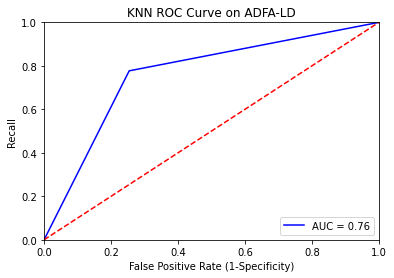

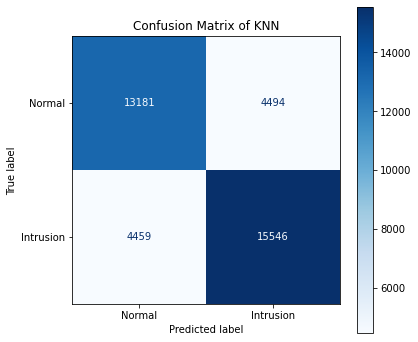

[[13181  4494]
 [ 4459 15546]]
Train AUC: 0.869 vs Test AUC: 0.761


In [62]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = {}
KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
KNN_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('KNN', KNN, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = {}
KNN_test['fpr'], KNN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KNN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(KNN_train['auc'], KNN_test['auc']))

# **Naive Bayes**

Confusion Matrix: 
 [[ 9526  8149]
 [ 7640 12365]]

Testing Accuracy: 0.58
Precision:0.60
Recall: 0.62
False Positive Rate: 0.46

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.54      0.55     17675
           1       0.60      0.62      0.61     20005

    accuracy                           0.58     37680
   macro avg       0.58      0.58      0.58     37680
weighted avg       0.58      0.58      0.58     37680

AUC: 0.58


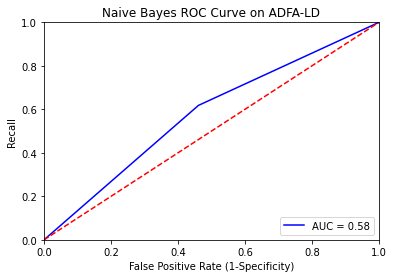

Train AUC: 0.579 vs Test AUC: 0.579


In [63]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = NaiveBayes.predict(x_train)
NB_train = {}
NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
NB_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = NaiveBayes.predict(x_test)

# Print performance measures
print_performance('Naive Bayes',y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NB_test = {}
NB_test['fpr'], NB_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NB_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NB_train['auc'], NB_test['auc']))

# **BERT**


In [64]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 123 kB 2.8 MB/s 
     |████████████████████████████████| 90 kB 5.5 MB/s 
     |████████████████████████████████| 131 kB 10.6 MB/s 
     |████████████████████████████████| 8.0 MB 13.9 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 138 kB 51.3 MB/s 
     |████████████████████████████████| 127 kB 50.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [65]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [66]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts) 

train_labels = tuple(y_train.tolist())
test_labels = tuple(y_test.tolist())

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(87918, 87918, 37680, 37680)

In [67]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

100%|██████████| 231508/231508 [00:01<00:00, 181488.92B/s]


['3', '140', '3', '192', '3', '6']

In [68]:
# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )       

Number of Training Sequences: 87918 
Number of Testing Sequences: 37680


In [69]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((87918, 20), (37680, 20))

In [70]:
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((87918,), (37680,), 0.5286971951136286, 0.5309182590233545)

In [71]:
# To mask the paddings
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [72]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [74]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

100%|██████████| 407873900/407873900 [00:32<00:00, 12641689.17B/s]


**Fine Tune BERT**

In [75]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks,2,128)

Epoch:  2
686/686.859375 loss: 0.23819472995387414 


**Evaluate on Testing Set**

In [76]:
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

# Convert to tensro for maks
test_masks_tensor = torch.tensor(test_masks)

# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Defile test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [77]:
bert_clf.eval() # Define eval
bert_predicted = [] # To Store predicted result
all_logits = [] # Actual output that is between 0 to 1 is stored here
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

Confusion Matrix: 
 [[16234  1441]
 [ 2029 17976]]

Testing Accuracy: 0.91
Precision:0.93
Recall: 0.90
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

       False       0.89      0.92      0.90     17675
        True       0.93      0.90      0.91     20005

    accuracy                           0.91     37680
   macro avg       0.91      0.91      0.91     37680
weighted avg       0.91      0.91      0.91     37680

AUC: 0.91


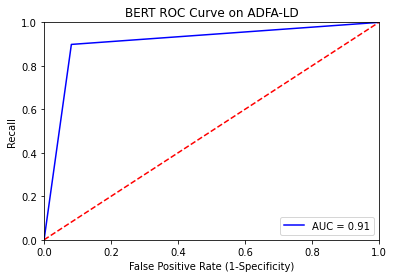

In [78]:
print_performance('BERT',test_y, bert_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
BERT_test = {}
BERT_test['fpr'], BERT_test['tpr'], thresh = roc_curve(test_y, bert_predicted)
BERT_test['auc'] = roc_auc_score(test_y, bert_predicted)

# **GPT-2**

In [79]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 39.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 33.3 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [80]:
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [81]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)
test_tokens = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [82]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

(torch.Size([87918, 6]), torch.Size([37680, 6]))

In [83]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

**Create GPT-2 Classifer**

In [84]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [85]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks,2, 128)

Epoch:  2
686/686.859375 loss: 0.27607454323742586 


**Evaluate on Testing Set**

In [87]:
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

test_masks_tensor = torch.tensor(test_masks)


test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [88]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

Confusion Matrix: 
 [[15800  1875]
 [ 2161 17844]]

Testing Accuracy: 0.89
Precision:0.90
Recall: 0.89
False Positive Rate: 0.11

Classification report:
              precision    recall  f1-score   support

       False       0.88      0.89      0.89     17675
        True       0.90      0.89      0.90     20005

    accuracy                           0.89     37680
   macro avg       0.89      0.89      0.89     37680
weighted avg       0.89      0.89      0.89     37680

AUC: 0.89


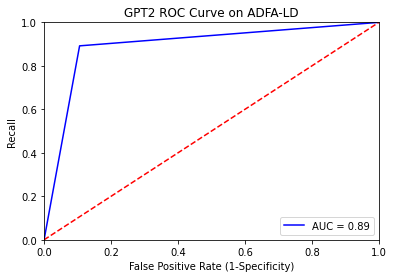

In [89]:
print_performance('GPT2',test_y, gpt_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
GPT_test = {}
GPT_test['fpr'], GPT_test['tpr'], thresh = roc_curve(test_y, gpt_predicted)
GPT_test['auc'] = roc_auc_score(test_y, gpt_predicted) 

# **Graphing multi-ROC Curves**

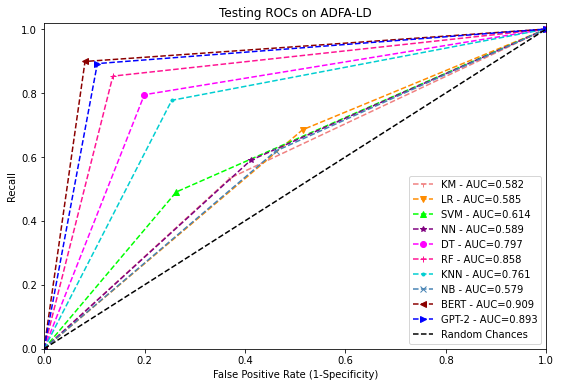

In [90]:
# Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()